In [1]:
%matplotlib inline

[link text](https://)
Sequence-to-Sequence Modeling with nn.Transformer and TorchText
===============================================================

This is a tutorial on how to train a sequence-to-sequence model
that uses the
`nn.Transformer <https://pytorch.org/docs/master/nn.html?highlight=nn%20transformer#torch.nn.Transformer>`__ module.

PyTorch 1.2 release includes a standard transformer module based on the
paper `Attention is All You
Need <https://arxiv.org/pdf/1706.03762.pdf>`__. The transformer model
has been proved to be superior in quality for many sequence-to-sequence
problems while being more parallelizable. The ``nn.Transformer`` module
relies entirely on an attention mechanism (another module recently
implemented as `nn.MultiheadAttention <https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention>`__) to draw global dependencies
between input and output. The ``nn.Transformer`` module is now highly
modularized such that a single component (like `nn.TransformerEncoder <https://pytorch.org/docs/master/nn.html?highlight=nn%20transformerencoder#torch.nn.TransformerEncoder>`__
in this tutorial) can be easily adapted/composed.

![](https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/_static/img/transformer_architecture.jpg?raw=1)





In [2]:
import math
import numpy as np
import os
import sys
import time

import torch
import torch.nn as nn
from torchtext.datasets import WikiText2

In [3]:
print(sys.version)
print(sys.prefix)

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
/media/homes/msmart/Development/VENVS/HLML2021


In [4]:
LOCAL_MS = os.path.dirname(os.path.abspath(''))
sys.path.append(LOCAL_MS)

from model import TransformerModel, load_model, train, evaluate
from model_usage import gen_some_text
from model_utils import gen_tokenizer_and_vocab, data_process, batchify, get_batch
from settings import BPTT

**Handler: Set Device (CUDA)**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('torch.cuda.is_available():', torch.cuda.is_available())
print('Device:', device)

torch.cuda.is_available(): True
Device: cuda


**Handler: Colab vs. Local Jupyter**

In [6]:
IN_COLAB = 'google.colab' in str(get_ipython())

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    NOTEBOOK_OUTDIR = 'MyDrive' + os.sep + 'output'
    %cd '/content/drive'
    TESTMODE = False
    batch_size = 64 #32
    eval_batch_size = 64 #32
    epochs = 50  # The number of epochs
else:
    NOTEBOOK_OUTDIR = 'output'
    TESTMODE = False       # True
    if torch.cuda.is_available():
        batch_size = 64       # 3, or 64/128 on server gpu
        eval_batch_size = 64  # 3, or 64/128 on server gpu
    else:
        batch_size = 3        # 3 on cpu
        eval_batch_size = 3   # 3 on cpu
    epochs = 50  # The number of epochs

os.makedirs(NOTEBOOK_OUTDIR, exist_ok=True)
DATADIR = NOTEBOOK_OUTDIR + os.sep + '.data'

print('Running in colab:', IN_COLAB)
print('Notebook output dir:', NOTEBOOK_OUTDIR)

Running in colab: False
Notebook output dir: output


Define the model
----------------




In this tutorial, we train ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words. A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
`nn.TransformerEncoderLayer <https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLayer>`__. Along with the input sequence, a square
attention mask is required because the self-attention layers in
``nn.TransformerEncoder`` are only allowed to attend the earlier positions in
the sequence. For the language modeling task, any tokens on the future
positions should be masked. To have the actual words, the output
of ``nn.TransformerEncoder`` model is sent to the final Linear
layer, which is followed by a log-Softmax function.




``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.




Load and batch data
-------------------




This tutorial uses ``torchtext`` to generate Wikitext-2 dataset. The
vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Starting from sequential data, the ``batchify()``
function arranges the dataset into columns, trimming off any tokens remaining
after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26)
and a batch size of 4, we would divide the alphabet into 4 sequences of
length 6:

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

These columns are treated as independent by the model, which means that
the dependence of ``G`` and ``F`` can not be learned, but allows more
efficient batch processing.




In [7]:
tokenizer, vocab = gen_tokenizer_and_vocab()

train_iter, val_iter, test_iter = WikiText2(root=DATADIR)
train_data = data_process(train_iter, vocab, tokenizer)
val_data = data_process(val_iter, vocab, tokenizer)
test_data = data_process(test_iter, vocab, tokenizer)

train_data = batchify(train_data, batch_size, device)
val_data = batchify(val_data, eval_batch_size, device)
test_data = batchify(test_data, eval_batch_size, device)

**Code Testing block: shorten the size of the training data to make training loop quicker**

In [8]:
data_reduce = 0.05

if TESTMODE:
    print('TRUNCATING DATA (testmode_ipynb=True)\nShapes before:')
    print(train_data.shape)
    print(test_data.shape)
    print(val_data.shape)
    train_data = train_data[0:int(data_reduce * train_data.shape[0]), :]
    test_data = test_data[0:int(data_reduce * test_data.shape[0]), :]
    val_data = val_data[0:int(data_reduce * val_data.shape[0]), :]
    print('Shapes after:')
    print(train_data.shape)
    print(test_data.shape)
    print(val_data.shape)

``get_batch()`` function generates the input and target sequence for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

![](https://github.com/pytorch/tutorials/blob/gh-pages/_downloads/_static/img/transformer_input_target.png?raw=1)


It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.




In [9]:
assert BPTT == 35  # TODO override/add flexibility later

Initiate an instance
--------------------




The model is set up with the hyperparameter below. The vocab size is
equal to the length of the vocab object.




In [10]:
ntokens = len(vocab.stoi) # the size of vocabulary

# Model 'A'
"""emsize = 200           # embedding dimension
nhid = 200                # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2               # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2                 # the number of heads in the multiheadattention models
dropout = 0.05            # the dropout value"""

# Model 'B'
emsize = 512              # embedding dimension
nhid = 2048               # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12              # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8                 # the number of heads in the multiheadattention models
dropout = 0.3             # the dropout value

# Model 'C'
"""
emsize = 1024             # embedding dimension
nhid = 2048               # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12              # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 16                # the number of heads in the multiheadattention models
dropout = 0.3             # the dropout value"""

# Model 'D' - like GPT-1 - it doesn't fit
# - "BPE with 40,000 merged [53]" using spaCy tokenizer
# - 512 token samples (their BPTT)
# - 100 epochs on minibatches of 64 continuous text streams (each of length BPTT)
# - adam 2.5e-4 with specific LR schedule
# - weight init of N(0, 0.02)
"""
emsize = 768              # embedding dimension
nhid = 3072               # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12              # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 12                # the number of heads in the multiheadattention models
dropout = 0.1             # the dropout value"""

model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

Run the model
-------------




`CrossEntropyLoss <https://pytorch.org/docs/master/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss>`__
is applied to track the loss and
`SGD <https://pytorch.org/docs/master/optim.html?highlight=sgd#torch.optim.SGD>`__
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0. `StepLR <https://pytorch.org/docs/master/optim.html?highlight=steplr#torch.optim.lr_scheduler.StepLR>`__ is
applied to adjust the learn rate through epochs. During the
training, we use
`nn.utils.clip_grad_norm\_ <https://pytorch.org/docs/master/nn.html?highlight=nn%20utils%20clip_grad_norm#torch.nn.utils.clip_grad_norm_>`__
function to scale all the gradient together to prevent exploding.




In [11]:
criterion = nn.CrossEntropyLoss()

optimizer_str = 'adam'
schedule_str = 'scheduleA'

valid_optimizer_str = ['SGD', 'adam', 'adamW']
valid_schedule_str = ['constant', 'scheduleA']
assert optimizer_str in valid_optimizer_str
assert schedule_str in valid_schedule_str

if optimizer_str == 'SGD':
    lr = 0.5  # learning rate (originally: 5.0, 0.1, 0.5 (best))
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    gamma = 0.95
elif optimizer_str == 'adam':
    lr = 1e-4  # default 1e-3, best 1e-4, try also 2.5e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    gamma = 0.9
else:
    assert optimizer_str == 'adamW'
    lr = 2.5e-4  # default 1e-3, best 1e-4
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    gamma = 0.9

if schedule_str == 'constant':
    scheduler = lr
else:
    assert schedule_str == 'scheduleA'
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=gamma)
    
# TODO try two-stage LR like in GPT-1 -- increase 0 to eta_0 over k steps then cosine schedule after

Optionally generate text each epoch to illustrate model state during training

In [12]:
gen_text_each_epoch = True
# default behaviour generate sentence 1 greedily, then nseed sentences with beta=1
if gen_text_each_epoch:
    text_prompt = 'The dog ran'
    decode_seeds = [0, 1, 2]
    decode_betas = [1.0, 1.0, 1.0]
    nongreedy_style = 'sample_full'
    
def gen_some_text_wrapper(generator_model, decode_style, decode_seed=0, decode_beta=1.0):
    generated_text = gen_some_text(
        generator_model, tokenizer, vocab, device,
        text_prompt=text_prompt,
        tokens_to_gen=25,
        decode_style=decode_style,
        decode_seed=decode_seed,
        decode_beta=decode_beta,
        sidestep_unk=False,
        vis=False,
        verbose=False)
    return generated_text

def decode_during_training(generator_model, epoch):
    
    decode_start_time = time.time()
    
    print('Generated text at epoch %d: %s ...' % (epoch, text_prompt))
    # First get greedy decoding
    greedy_text = gen_some_text_wrapper(generator_model, 'greedy')
    print("Greedy decoding:\n\t%s" % (greedy_text))
    # Now get several sampler decodings
    for idx in range(len(decode_seeds)):
        generated_text = gen_some_text_wrapper(generator_model, nongreedy_style, decode_seeds[idx], decode_betas[idx])
        print("(%s, seed=%d, beta=%.2f):\n\t%s" % (nongreedy_style, decode_seeds[idx], decode_betas[idx], generated_text))
    print('-' * 89)
    print('Epoch {:3d} | example generation time: {:5.2f}s'.format(epoch, (time.time() - decode_start_time)))
    print('-' * 89)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [13]:
batch_per_epoch = len(train_data) // BPTT
if (len(train_data) - 1) % BPTT != 0:
    batch_per_epoch += 1

training_ppl_train_fine = np.zeros(epochs * batch_per_epoch)
training_ppl_val_coarse = np.zeros(epochs)

best_val_loss = float("inf")
best_model = None

if gen_text_each_epoch:
    decode_during_training(model, 0)

for epoch in range(1, epochs + 1):
        
    epoch_start_time = time.time()
    loss_per_batch = train(model, device, train_data, ntokens, optimizer, scheduler, criterion, epoch)
    
    # print validation loss info each epoch
    validation_loss = evaluate(model, val_data, device, ntokens, criterion)
    validation_ppl = math.exp(validation_loss)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     validation_loss, validation_ppl))
    print('-' * 89)
    
    # store loss info
    training_ppl_val_coarse[epoch-1] = validation_ppl
    training_ppl_train_fine[(epoch-1) * batch_per_epoch: (epoch)*batch_per_epoch] = np.exp(loss_per_batch)
    
    # save best model so far
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        torch.save(model.state_dict(), NOTEBOOK_OUTDIR + os.sep + 'bestval_model_weights.pth')
        torch.save(model, NOTEBOOK_OUTDIR + os.sep + 'bestval_model.pth')
    if not(isinstance(scheduler, int) or isinstance(scheduler, float)):
        scheduler.step()
            
    # optionally generate text based on fixed text-prompt
    if gen_text_each_epoch:
        decode_during_training(model, epoch)

Generated text at epoch 0: The dog ran ...
Greedy decoding:
	 fritt fritt fritt fritt sticky sticky fritt fritt fritt fritt fritt fritt sticky sticky sticky sticky sticky sticky sticky voltage fritt sticky voltage tennis sticky
(sample_full, seed=0, beta=1.00):
	 argentina departures sought hurlford 1175 mares franchomme prunes position henry sad hanks adelson fredericksburg defaced cider conversation consent thicker rick pratt vegetarian widowed strangers disaffected
(sample_full, seed=1, beta=1.00):
	 balad active darke shawnna poll hired khitans bits alex chasuble squadrons douglas citadel politics conformation tennis devotee vira bjørn prospered presses nine work ticks scarlet
(sample_full, seed=2, beta=1.00):
	 substituted stylish mozart sanctions agitation satellites tv ransome 1955 mügge peaks excellent nicknames effects minustah signal mites kahne predominant landmarks unrepentant mt precaution fannie atomics
---------------------------------------------------------------------

(sample_full, seed=1, beta=1.00):
	 through the relation of most than the structure . as illinois , five years later . the captain <unk> the assembly , work think scarlet
(sample_full, seed=2, beta=1.00):
	 when the assassination was in this best new zealand times was romantically completely governed by iguanodon iii , after this enabled in london . he
-----------------------------------------------------------------------------------------
Epoch   5 | example generation time:  1.21s
-----------------------------------------------------------------------------------------
| epoch   6 |   200/  915 batches | lr 5.904900e-05 | ms/batch 197.00 | loss  5.42 | ppl   226.46
| epoch   6 |   400/  915 batches | lr 5.904900e-05 | ms/batch 196.13 | loss  5.37 | ppl   214.60
| epoch   6 |   600/  915 batches | lr 5.904900e-05 | ms/batch 196.14 | loss  5.31 | ppl   201.70
| epoch   6 |   800/  915 batches | lr 5.904900e-05 | ms/batch 196.12 | loss  5.32 | ppl   205.38
-----------------------------

| epoch  11 |   200/  915 batches | lr 3.486784e-05 | ms/batch 197.42 | loss  5.04 | ppl   154.58
| epoch  11 |   400/  915 batches | lr 3.486784e-05 | ms/batch 196.42 | loss  4.99 | ppl   147.41
| epoch  11 |   600/  915 batches | lr 3.486784e-05 | ms/batch 196.41 | loss  4.95 | ppl   140.75
| epoch  11 |   800/  915 batches | lr 3.486784e-05 | ms/batch 196.65 | loss  4.98 | ppl   144.96
-----------------------------------------------------------------------------------------
| end of epoch  11 | time: 185.17s | valid loss  5.10 | valid ppl   164.73
-----------------------------------------------------------------------------------------
Generated text at epoch 11: The dog ran ...
Greedy decoding:
	 to the <unk> of the <unk> <unk> . the <unk> of the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
(sample_full, seed=0, beta=1.00):
	 to le llosa ' s label judge . = henry = = although <unk> , named in the new zealand , hergé widowed leader was
(sample_full, 

Generated text at epoch 16: The dog ran ...
Greedy decoding:
	 into the <unk> of the <unk> . the <unk> of the <unk> , the <unk> , was the first <unk> of the <unk> <unk> ,
(sample_full, seed=0, beta=1.00):
	 to le diable . = = judge and position = = = although beginning with his children being considered a wife , dershowitz learns that
(sample_full, seed=1, beta=1.00):
	 through the french bc poll , including some of which were unable to be relegated . the captain <unk> rodríguez pullo visited work on scarlet
(sample_full, seed=2, beta=1.00):
	 when she received brainwashed in a tv padres . john was romantically completely threatening a signal 6 @ , @ 000 in london , when
-----------------------------------------------------------------------------------------
Epoch  16 | example generation time:  1.23s
-----------------------------------------------------------------------------------------
| epoch  17 |   200/  915 batches | lr 1.853020e-05 | ms/batch 197.69 | loss  4.84 | ppl   126.0

| epoch  22 |   200/  915 batches | lr 1.094190e-05 | ms/batch 197.33 | loss  4.75 | ppl   116.02
| epoch  22 |   400/  915 batches | lr 1.094190e-05 | ms/batch 196.45 | loss  4.70 | ppl   110.37
| epoch  22 |   600/  915 batches | lr 1.094190e-05 | ms/batch 196.39 | loss  4.66 | ppl   106.08
| epoch  22 |   800/  915 batches | lr 1.094190e-05 | ms/batch 196.50 | loss  4.70 | ppl   109.82
-----------------------------------------------------------------------------------------
| end of epoch  22 | time: 185.12s | valid loss  4.99 | valid ppl   147.42
-----------------------------------------------------------------------------------------
Generated text at epoch 22: The dog ran ...
Greedy decoding:
	 into the <unk> of the <unk> . the <unk> of the <unk> <unk> , the <unk> , was the first to be the first <unk>
(sample_full, seed=0, beta=1.00):
	 to le diable . = = judge and position = = = although asked for his conversation with lowell , the un correspondent learns that
(sample_full, seed

Generated text at epoch 27: The dog ran ...
Greedy decoding:
	 into the <unk> of the <unk> . the <unk> of the <unk> , the <unk> , was the first to be the first of the
(sample_full, seed=0, beta=1.00):
	 to le diable in rome and isabella captured munich henry ' s mother in <unk> to roll them . alexander , un widowed leader ,
(sample_full, seed=1, beta=1.00):
	 through the french eradication , forcing him to try to film a five @-@ year chance . captain <unk> rodríguez pullo said she think he
(sample_full, seed=2, beta=1.00):
	 when she received brainwashed in 1649 and joined the first magazine in the medieval country . the film ends with the <unk> of david <unk>
-----------------------------------------------------------------------------------------
Epoch  27 | example generation time:  1.19s
-----------------------------------------------------------------------------------------
| epoch  28 |   200/  915 batches | lr 5.814974e-06 | ms/batch 197.81 | loss  4.70 | ppl   110.04
| epoch  

| epoch  33 |   200/  915 batches | lr 3.433684e-06 | ms/batch 197.40 | loss  4.68 | ppl   107.94
| epoch  33 |   400/  915 batches | lr 3.433684e-06 | ms/batch 196.50 | loss  4.63 | ppl   102.57
| epoch  33 |   600/  915 batches | lr 3.433684e-06 | ms/batch 196.59 | loss  4.59 | ppl    98.85
| epoch  33 |   800/  915 batches | lr 3.433684e-06 | ms/batch 196.61 | loss  4.63 | ppl   102.41
-----------------------------------------------------------------------------------------
| end of epoch  33 | time: 185.20s | valid loss  4.97 | valid ppl   143.59
-----------------------------------------------------------------------------------------
Generated text at epoch 33: The dog ran ...
Greedy decoding:
	 into a <unk> , and the <unk> of the <unk> <unk> <unk> . the <unk> of the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
(sample_full, seed=0, beta=1.00):
	 to le diable in 1847 and isabella captured munich henry ' s mother in <unk> to roll them . alexander , un widowed leader ,
(sample_fu

Generated text at epoch 38: The dog ran ...
Greedy decoding:
	 into a <unk> , and the <unk> of the <unk> . the <unk> of the <unk> <unk> , the <unk> , was the first to
(sample_full, seed=0, beta=1.00):
	 to le diable . = = judge and position = = = schmoke finished banana basketball in 1943 by alexander after finishing the club operation
(sample_full, seed=1, beta=1.00):
	 through the adventures of john alexander ' s father , in a five @-@ year collection of science fiction the london museum and isabella scarlet
(sample_full, seed=2, beta=1.00):
	 when she received brainwashed in 1649 and joined 1955 . she romantically pursued her a signal 6 @ , @ 000 men , one opened
-----------------------------------------------------------------------------------------
Epoch  38 | example generation time:  1.26s
-----------------------------------------------------------------------------------------
| epoch  39 |   200/  915 batches | lr 1.824800e-06 | ms/batch 197.59 | loss  4.67 | ppl   107.03
| e

| epoch  44 |   200/  915 batches | lr 1.077526e-06 | ms/batch 197.38 | loss  4.68 | ppl   107.32
| epoch  44 |   400/  915 batches | lr 1.077526e-06 | ms/batch 196.66 | loss  4.63 | ppl   102.11
| epoch  44 |   600/  915 batches | lr 1.077526e-06 | ms/batch 196.59 | loss  4.59 | ppl    98.19
| epoch  44 |   800/  915 batches | lr 1.077526e-06 | ms/batch 196.62 | loss  4.62 | ppl   101.67
-----------------------------------------------------------------------------------------
| end of epoch  44 | time: 185.29s | valid loss  4.96 | valid ppl   141.99
-----------------------------------------------------------------------------------------
Generated text at epoch 44: The dog ran ...
Greedy decoding:
	 from the <unk> of the <unk> . the <unk> of the <unk> <unk> , the <unk> , was a <unk> , and the <unk> of
(sample_full, seed=0, beta=1.00):
	 to le diable . = = judge and position = = = schmoke finished banana basketball in the lowell , after finishing 1 – 1
(sample_full, seed=1, beta=1.00):

Greedy decoding:
	 from the <unk> of the <unk> . the <unk> of the <unk> <unk> , the <unk> , was the first to be the first of
(sample_full, seed=0, beta=1.00):
	 to le diable . = = judge and position = = = schmoke finished banana basketball in the lowell , after finishing 1 – 1
(sample_full, seed=1, beta=1.00):
	 through the 2 @ , @ 900 miles ( 1 @ , @ 000 km ) across the afternoon , providing nine main rounds of
(sample_full, seed=2, beta=1.00):
	 when she received brainwashed in 1649 and joined 1955 . she romantically pursued her a signal 6 @ , @ 000 men , using six
-----------------------------------------------------------------------------------------
Epoch  49 | example generation time:  1.30s
-----------------------------------------------------------------------------------------
| epoch  50 |   200/  915 batches | lr 5.726417e-07 | ms/batch 197.41 | loss  4.69 | ppl   108.90
| epoch  50 |   400/  915 batches | lr 5.726417e-07 | ms/batch 196.87 | loss  4.64 | ppl   103.96
| epoc

**Save Model**

Approach 1: save model weights,
load as: 

  `model.load_state_dict(torch.load('model_weights.pth'))`    
  `model.eval()`
  
Approach 2: save model class object entirely (uses pickle),
load as: 
  `model = torch.load('model.pth')`

In [14]:
torch.save(model.state_dict(), NOTEBOOK_OUTDIR + os.sep + 'end_model_weights.pth')
torch.save(model, NOTEBOOK_OUTDIR + os.sep + 'end_model.pth')

Evaluate the model with the test dataset
-------------------------------------

Assess the model from the end of training (last epoch) on test set.

In [15]:
datachoices = {'train': train_data, 
               'val': val_data,
               'test': test_data}

for datalabel in ['train', 'val', 'test']:
    data_loss = evaluate(model, datachoices[datalabel], device, ntokens, criterion)
    print('=' * 89)
    print('| End of training | {} loss {:5.2f} | {} ppl {:8.2f}'.format(
        datalabel, data_loss, datalabel, math.exp(data_loss)))
    print('=' * 89)

| End of training | train loss  4.42 | train ppl    83.48
| End of training | val loss  4.94 | val ppl   140.30
| End of training | test loss  4.87 | test ppl   129.79


Load the best model (lowest validation loss) to check the result with the test dataset.

In [16]:
best_model = load_model(NOTEBOOK_OUTDIR + os.sep + 'bestval_model.pth',
                        device, 
                        as_pickle=True)

datachoices = {'train': train_data, 
               'val': val_data,
               'test': test_data}

for datalabel in ['train', 'val', 'test']:
    data_loss = evaluate(best_model, datachoices[datalabel], device, ntokens, criterion)
    print('=' * 89)
    print('| Best model | {} loss {:5.2f} | {} ppl {:8.2f}'.format(
        datalabel, data_loss, datalabel, math.exp(data_loss)))
    print('=' * 89)

| Best model | train loss  4.42 | train ppl    83.48
| Best model | val loss  4.94 | val ppl   140.30
| Best model | test loss  4.87 | test ppl   129.79


# Plot training timeseries

In [17]:
np.savetxt(NOTEBOOK_OUTDIR + os.sep + 'training_ppl_train_fine.txt', training_ppl_train_fine)
np.savetxt(NOTEBOOK_OUTDIR + os.sep + 'training_ppl_val_coarse.txt', training_ppl_val_coarse)

In [18]:
import matplotlib.pyplot as plt

epochs_axis = np.arange(1, epochs + 1)
epochs_axis_fine = np.linspace(0, epochs, epochs * batch_per_epoch + 1)[:-1]

def plot_training_timeseries(fname='training_performance', ext='.jpg', logy=True, xlims=None, ylims=None):

    plt.figure(figsize=(8,6))
    plt.plot(epochs_axis, training_ppl_val_coarse, '--ok', label='val', zorder=2)
    plt.plot(epochs_axis_fine, training_ppl_train_fine, 'b', label='train', zorder=1, alpha=0.5)
    plt.xlabel('epoch')
    plt.ylabel('ppl (validation set)')
    plt.legend()
    if logy:
        plt.yscale('log')
        fname += '_logy'
    if xlims is not None:
        plt.xlim(xlims[0], xlims[1])
    if ylims is not None:
        plt.ylim(ylims[0], ylims[1])
    plt.savefig(NOTEBOOK_OUTDIR + os.sep + fname + ext)
    plt.show()

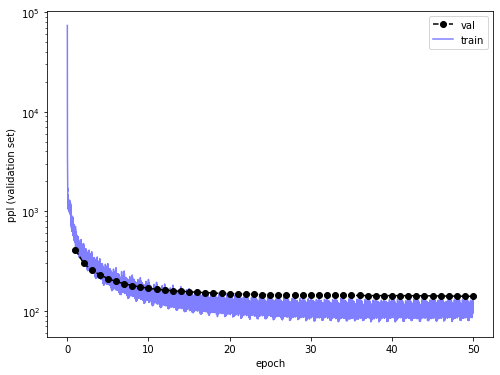

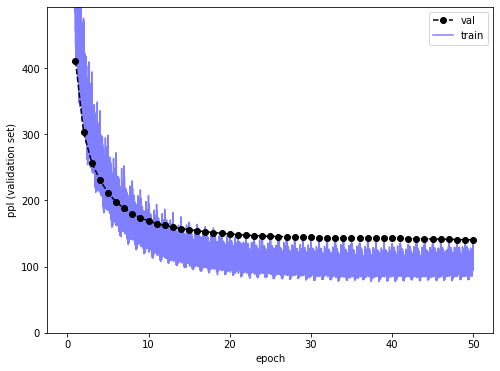

In [19]:
plot_training_timeseries(logy=True)
plot_training_timeseries(logy=False, ylims=(0, np.max(training_ppl_val_coarse) * 1.2))

In [20]:
print('Epoch after which validation loss is minimized (defines best_model):', np.argmin(training_ppl_val_coarse) + 1)

Epoch after which validation loss is minimized (defines best_model): 50
